Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [x] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [x] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [x] Do one-hot encoding of categorical features.
- [x] Do feature selection with `SelectKBest`.
- [x] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [x] Get mean absolute error for the test set.
- [x] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv', thousands=',')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [3]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [4]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

## Task 1

- Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.

In [5]:
df2 = df[(df["BUILDING_CLASS_CATEGORY"] == "01 ONE FAMILY DWELLINGS") & ((df["SALE_PRICE"] > 100000) & (df["SALE_PRICE"] < 2000000))]

## Task 2
- Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [67]:
df2.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [6]:
df2['SALE_DATE'] = pd.to_datetime(df2['SALE_DATE'], infer_datetime_format=True)

In [7]:
train_set = df2[df2['SALE_DATE'] < pd.to_datetime("2019-04-01")]
test_set = df2[df2['SALE_DATE'] >= pd.to_datetime("2019-04-01")]

In [22]:
train = {
    "x": train_set.drop('SALE_PRICE', axis = 1),
    "y": train_set['SALE_PRICE']
}
test = {
    "x": test_set.drop('SALE_PRICE', axis = 1),
    "y": test_set['SALE_PRICE']
}
train['y']


44       550000
61       200000
78       810000
108      125000
111      620000
          ...  
18129    330000
18130    690000
18132    610949
18134    520000
18147    104000
Name: SALE_PRICE, Length: 2507, dtype: int64

In [71]:
train['x'].describe(exclude="number")

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2507,2507,2507,2507,2507,2507,1,2507,2507,2507
unique,5,6,1,2,13,2497,1,887,11,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,22-40 93RD STREET,RP.,"4,000",A1,2019-01-31 00:00:00
freq,1204,2382,2507,2476,919,2,1,234,919,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


## Task 3
- Do one-hot encoding of categorical features.

In [11]:
(train['x'].select_dtypes(exclude = 'number').nunique())

BOROUGH                              5
NEIGHBORHOOD                         7
BUILDING_CLASS_CATEGORY              1
TAX_CLASS_AT_PRESENT                 2
BUILDING_CLASS_AT_PRESENT           13
ADDRESS                           2497
APARTMENT_NUMBER                     1
LAND_SQUARE_FEET                   887
BUILDING_CLASS_AT_TIME_OF_SALE      11
SALE_DATE                           68
dtype: int64

In [86]:
columns_to_encode = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT',
       'BUILDING_CLASS_AT_TIME_OF_SALE']

In [76]:
pd.to_numeric(train['x']['LAND_SQUARE_FEET'].str.replace(',',''), errors='coerce')

44       6800
61       4000
78       3500
108      4000
111      1710
         ... 
18129    2400
18130    2450
18132    4361
18134    6000
18147    3910
Name: LAND_SQUARE_FEET, Length: 2507, dtype: int64

In [23]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)

def one_hot_df(df:pd.DataFrame, encoder=None):
    df = df.drop('EASE-MENT', axis=1).copy()
    df["LAND_SQUARE_FEET"] = pd.to_numeric(df['LAND_SQUARE_FEET'].str.replace(',',''), errors='coerce')
    df = df.drop(['APARTMENT_NUMBER','BUILDING_CLASS_CATEGORY'], axis=1)
    high_cardinality = ['ADDRESS', 'SALE_DATE']
    numerical = df.select_dtypes(include="number")
    categorical = df.select_dtypes(exclude="number").drop(high_cardinality, axis=1)
    if not encoder:
        encoder = ce.OneHotEncoder(use_cat_names=True)
        categorical = encoder.fit_transform(categorical)
    else:
        categorical = encoder.transform(categorical)
    merge_keys = {"left_index":True, "right_index":True}
    return numerical.merge(categorical, left_index=True, right_index=True), encoder

In [24]:
train['x'], encoder = one_hot_df(train['x'])
test['x'], encoder = one_hot_df(test['x'], encoder)

In [26]:
test['x']

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,...,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
18235,5913,878,10471.0,1.0,0.0,1.0,5000,2272.0,1930.0,1,...,1,0,0,0,0,0,0,0,0,0
18239,5488,48,10465.0,1.0,0.0,1.0,2500,720.0,1935.0,1,...,0,0,0,1,0,0,0,0,0,0
18244,5936,31,11209.0,1.0,0.0,1.0,2880,2210.0,1925.0,1,...,1,0,0,0,0,0,0,0,0,0
18280,7813,24,11210.0,1.0,0.0,1.0,1305,1520.0,1915.0,1,...,0,1,0,0,0,0,0,0,0,0
18285,8831,160,11229.0,1.0,0.0,1.0,1800,840.0,1925.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,13215,3,11422.0,1.0,0.0,1.0,3300,1478.0,1925.0,1,...,0,0,0,1,0,0,0,0,0,0
23031,11612,73,11420.0,1.0,0.0,1.0,2400,1280.0,1930.0,1,...,1,0,0,0,0,0,0,0,0,0
23032,11808,50,11420.0,1.0,0.0,1.0,4000,1333.0,1945.0,1,...,0,0,1,0,0,0,0,0,0,0
23033,12295,23,11434.0,1.0,0.0,1.0,2500,1020.0,1935.0,1,...,1,0,0,0,0,0,0,0,0,0


In [27]:
train['x']

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,...,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,5495,801,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,...,0,0,0,0,0,0,0,0,0,0
61,7918,72,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,...,1,0,0,0,0,0,0,0,0,0
78,4210,19,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1,...,1,0,0,0,0,0,0,0,0,0
108,5212,69,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1,...,1,0,0,0,0,0,0,0,0,0
111,7930,121,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,4081,44,10306.0,1.0,0.0,1.0,2400,921.0,1950.0,1,...,0,0,0,1,0,0,0,0,0,0
18130,2373,201,10314.0,1.0,0.0,1.0,2450,2128.0,1980.0,1,...,0,1,0,0,0,0,0,0,0,0
18132,1132,42,10302.0,1.0,0.0,1.0,4361,1807.0,2018.0,1,...,1,0,0,0,0,0,0,0,0,0
18134,3395,37,10305.0,1.0,0.0,1.0,6000,621.0,1930.0,1,...,0,0,0,1,0,0,0,0,0,0


## Task 4
- Do feature selection with `SelectKBest`.

In [54]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression)

In [55]:
selector.fit_transform(train['x'], train['y'])

array([[11230.,  6800.,  1325., ...,     0.,     0.,     0.],
       [11427.,  4000.,  2001., ...,     0.,     0.,     0.],
       [10461.,  3500.,  2043., ...,     0.,     0.,     0.],
       ...,
       [10302.,  4361.,  1807., ...,     0.,     0.,     0.],
       [10305.,  6000.,   621., ...,     0.,     0.,     0.],
       [11429.,  3910.,  1163., ...,     0.,     0.,     0.]])

In [51]:
mask = selector.get_support()


In [52]:
train['x'].columns[mask]

Index(['ZIP_CODE', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'BOROUGH_3',
       'BOROUGH_2', 'BOROUGH_5', 'NEIGHBORHOOD_OTHER',
       'NEIGHBORHOOD_FOREST HILLS', 'BUILDING_CLASS_AT_PRESENT_A3',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A3'],
      dtype='object')

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

mae_list = []
for k in range(1, train['x'].shape[1]+1):
    print(f'{k} features')
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_kbest = selector.fit_transform(train['x'], train['y'])
    X_test_kbest = selector.transform(test['x'])
    model = LinearRegression()
    model.fit(X_train_kbest, train['y'])
    y_pred = model.predict(X_test_kbest)
    mae = mean_absolute_error(y_pred, test['y'])
    print(f'MAE on test set: ${mae:.2f}')
    mae_list.append(mae)

1 features
MAE on test set: $183640.59
2 features
MAE on test set: $179554.77
3 features
MAE on test set: $179291.47
4 features
MAE on test set: $179291.47
5 features
MAE on test set: $170482.97
6 features
MAE on test set: $169982.37
7 features
MAE on test set: $168139.67
8 features
MAE on test set: $168244.54
9 features
MAE on test set: $167855.35
10 features
MAE on test set: $164737.04
11 features
MAE on test set: $165346.03
12 features
MAE on test set: $164860.23
13 features
MAE on test set: $155159.40
14 features
MAE on test set: $156541.35
15 features
MAE on test set: $156571.59
16 features
MAE on test set: $156572.86
17 features
MAE on test set: $156393.75
18 features
MAE on test set: $156393.75
19 features
MAE on test set: $156255.32
20 features
MAE on test set: $156255.32
21 features
MAE on test set: $154395.61
22 features
MAE on test set: $154425.71
23 features
MAE on test set: $154425.71
24 features
MAE on test set: $154425.71
25 features
MAE on test set: $153929.40
26 featur

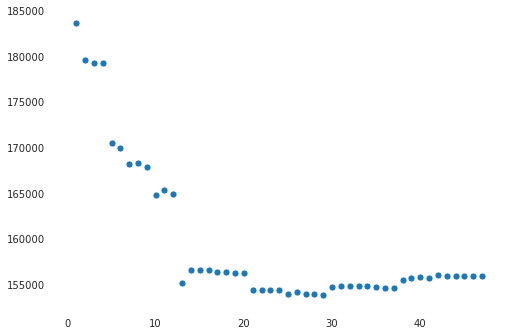

In [53]:
import seaborn as sns

sns.scatterplot(range(1, train['x'].shape[1]+1), mae_list)

In [56]:
selector = SelectKBest(f_regression, k=13)

In [57]:
train['k'] = selector.fit_transform(train['x'], train['y'])
test['k'] = selector.transform(test['x'])

In [61]:
columns = train['x'].columns[selector.get_support()]

In [67]:
train['k'] = pd.DataFrame(train['k'], columns = columns, index = train['x'].index)
test['k'] = pd.DataFrame(test['k'], columns = columns, index = test['x'].index)

## Task 5
- Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)

In [68]:
from sklearn.linear_model import Ridge, RidgeCV

In [81]:
ridge = Ridge(normalize=True)
ridge.fit(train['k'], train['y'])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [82]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(
ridge.predict(train['k']),
train['y'])

169484.71361652616

## Task 6
 - Mean Absolute Error on the test set

In [86]:
mean_absolute_error(
test['y'],
ridge.predict(test['k']))

169013.09550789918

## Stretch Goal
- Use `RidgeCV`

In [87]:
ridge_cv = RidgeCV(normalize=True)

In [89]:
ridge_cv.fit(train['k'], train['y'])

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=True, scoring=None, store_cv_values=False)

In [91]:
mean_absolute_error(test['y'], ridge_cv.predict(test['k']))

155984.77451024053